In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

In [2]:
# Generate a realistic synthetic dataset
def generate_synthetic_data(n_samples=2000):
    np.random.seed(42)
    # Feature generation
    income = np.random.lognormal(mean=11, sigma=0.6, size=n_samples)
    age = np.random.randint(22, 65, size=n_samples)
    loan_amount = np.random.lognormal(mean=9, sigma=0.8, size=n_samples)
    credit_utilization = np.random.beta(a=2, b=5, size=n_samples) * 100
    payment_history_score = np.random.randint(300, 850, size=n_samples)

    # Target variable generation (creditworthiness)
    # 1 for Good Credit, 0 for Bad Credit
    # Probability of good credit increases with income and payment history, decreases with loan amount and utilization
    prob_good_credit = 1 / (1 + np.exp(-(
        -12 + (income / 15000) + (payment_history_score / 100) - (loan_amount / 20000) - (credit_utilization / 20)
    )))
    
    credit_score = (np.random.rand(n_samples) < prob_good_credit).astype(int)

    df = pd.DataFrame({
        'income': income.round(2),
        'age': age,
        'loan_amount': loan_amount.round(2),
        'credit_utilization_percent': credit_utilization.round(2),
        'payment_history_score': payment_history_score,
        'credit_score': credit_score
    })
    return df

data = generate_synthetic_data()
print("Dataset created. Here's a preview:")
print(data.head())
print("\nDataset Info:")
data.info()

Dataset created. Here's a preview:
      income  age  loan_amount  credit_utilization_percent  \
0   80662.45   51      5639.30                       42.62   
1   55107.52   52     16577.12                       14.03   
2   88310.40   59     16668.88                       27.21   
3  149315.67   32     31280.61                       31.89   
4   52026.47   56     29691.34                        3.57   

   payment_history_score  credit_score  
0                    537             0  
1                    844             0  
2                    584             0  
3                    336             0  
4                    402             0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   income                      2000 non-null   float64
 1   age                         2000 non-null   int32

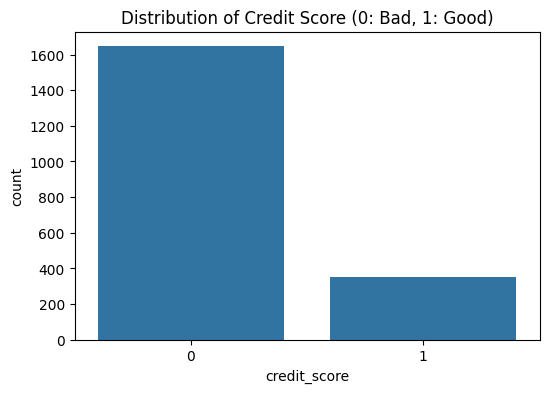

credit_score
0    0.8235
1    0.1765
Name: proportion, dtype: float64


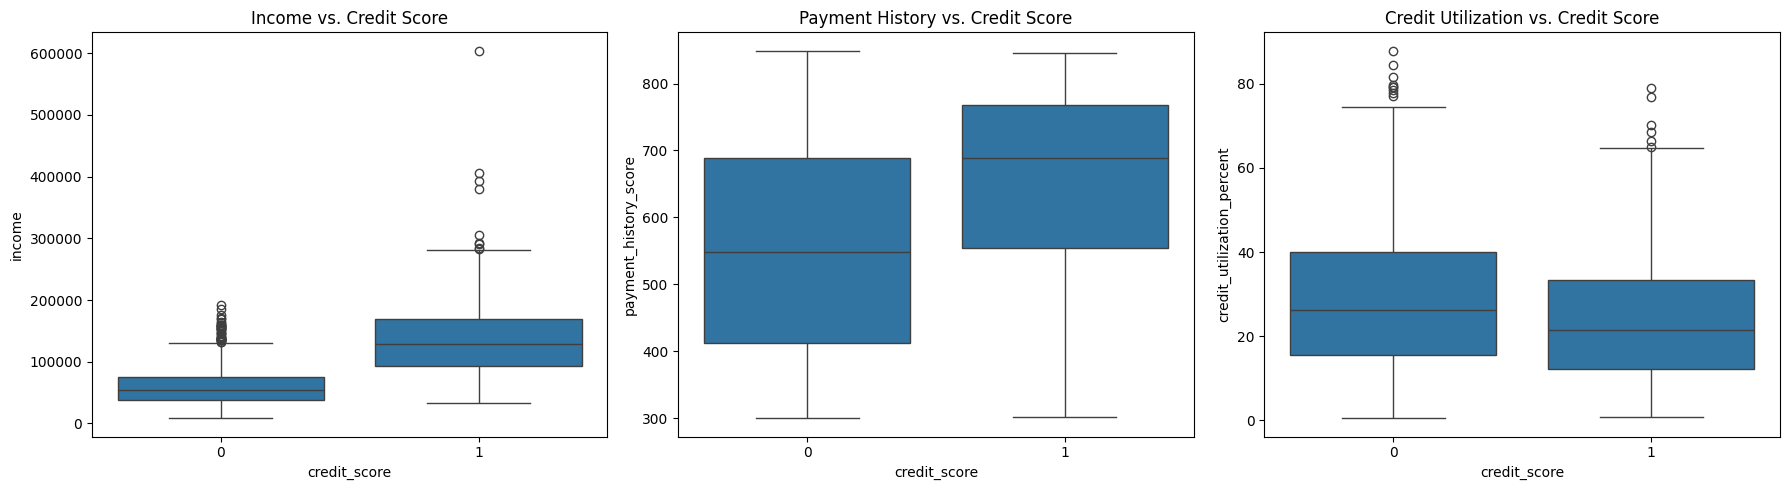

In [3]:
# Check target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='credit_score', data=data)
plt.title('Distribution of Credit Score (0: Bad, 1: Good)')
plt.show()

print(data['credit_score'].value_counts(normalize=True))

# Visualize relationships between features and the target
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(ax=axes[0], x='credit_score', y='income', data=data)
axes[0].set_title('Income vs. Credit Score')
sns.boxplot(ax=axes[1], x='credit_score', y='payment_history_score', data=data)
axes[1].set_title('Payment History vs. Credit Score')
sns.boxplot(ax=axes[2], x='credit_score', y='credit_utilization_percent', data=data)
axes[2].set_title('Credit Utilization vs. Credit Score')
plt.tight_layout()
plt.show()

In [4]:
# Feature Engineering
data['loan_to_income_ratio'] = data['loan_amount'] / data['income']
data['age_times_income'] = data['age'] * data['income']

# Define Features (X) and Target (y)
X = data.drop('credit_score', axis=1)
y = data['credit_score']

# Train-Test Split
# We use stratify=y to ensure the proportion of good/bad credit is the same in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale numerical features
# Scaling is crucial for Logistic Regression and improves performance for many other models.
# We fit the scaler ONLY on the training data to prevent data leakage from the test set.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for clarity
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\nEngineered features and scaled the data.")


Engineered features and scaled the data.


--- Training Logistic Regression ---
Precision: 0.8197
Recall: 0.5682
F1-Score: 0.6711
ROC-AUC Score: 0.9385

--- Training Decision Tree ---
Precision: 0.6087
Recall: 0.4773
F1-Score: 0.5350
ROC-AUC Score: 0.7429

--- Training Random Forest ---
Precision: 0.7500
Recall: 0.5114
F1-Score: 0.6081
ROC-AUC Score: 0.9168



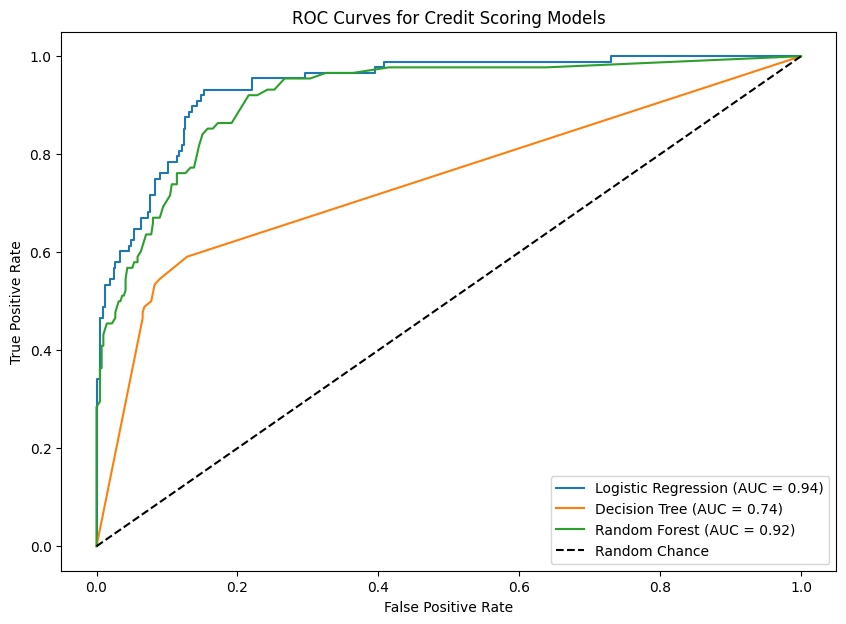

In [5]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"--- Training {name} ---")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] # Probabilities for the positive class

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    results[name] = {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}\n")

# Plot ROC Curves for all models
plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["ROC-AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Credit Scoring Models')
plt.legend()
plt.show()

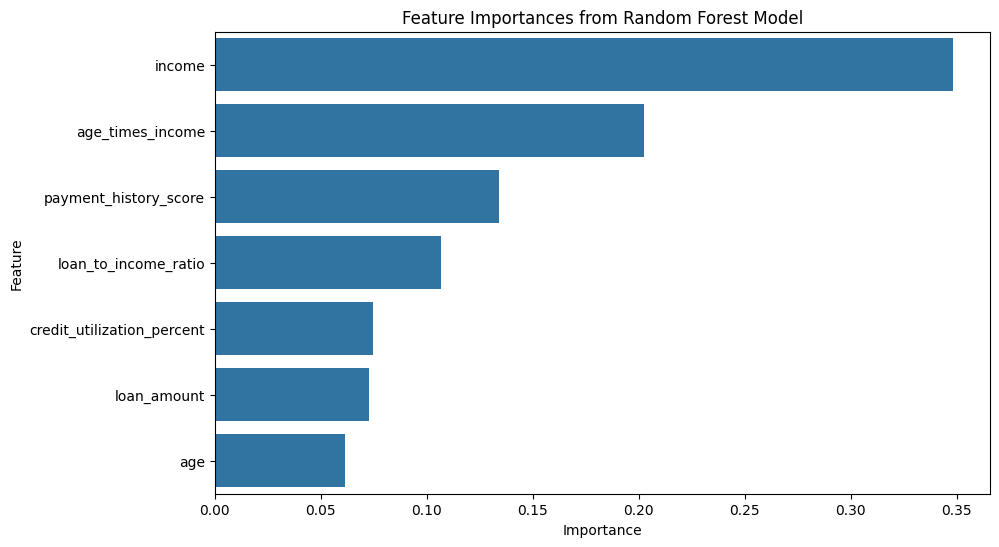


Top 5 Most Important Features:
                      Feature  Importance
0                      income    0.348270
6            age_times_income    0.202234
4       payment_history_score    0.133854
5        loan_to_income_ratio    0.106538
3  credit_utilization_percent    0.074757


In [6]:
# Assuming Random Forest is the best model
best_model = models["Random Forest"]

# Get feature importances
importances = best_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest Model')
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance_df.head())